In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.6-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 133.2MB 87kB/s 
     |████████████████████████████████| 61kB 2.7MB/s 
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12


In [ ]:
import torch
from torch import nn,optim
import torch.nn.functional as F

In [ ]:
from torchvision import datasets,transforms

# Define a transform to normalize the data 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
                                ])


# Download and load the training data
trainset = datasets.FashionMNIST('FashionMNIST_data/',download=True,train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)

Extracting FashionMNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST_data/FashionMNIST/raw


Extracting FashionMNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST_data/FashionMNIST/raw



Extracting FashionMNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST_data/FashionMNIST/raw


Extracting FashionMNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Defining the Network Architecture
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)


  def forward(self,x):
    # Make sure input tensor is flattened
    x = x.view(x.shape[0],-1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x),dim=1)

    return x


In [ ]:
# Create the network and define the criterion and optimizer
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=0.003)

In [ ]:
# Train the network
epochs = 5
for e in range(epochs):
  running_loss=0
  for images,labels in trainloader:
    logps = model(images)
    loss  = criterion(logps,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print('TRAINING LOSS : {}'.format(running_loss/len(trainloader)))

  

TRAINING LOSS : 0.5128690594676207
TRAINING LOSS : 0.39111529354220514
TRAINING LOSS : 0.3558982619201578
TRAINING LOSS : 0.33271096058205757
TRAINING LOSS : 0.3161739670852227


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

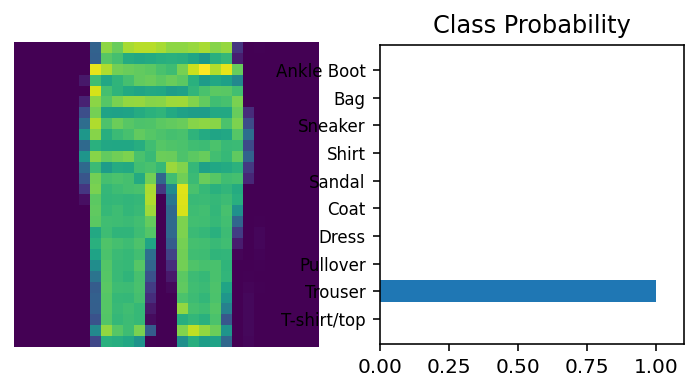

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Test your network
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = images[1]

# calculate class probability (softmax) for img
ps = torch.exp(model(img))

view_classify(img,ps,version='Fashion')


###Inference and Validation

In [ ]:
import torch
from torchvision import datasets,transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('FashionMNIST_data/',download=True,train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)

# Download and load the Test data
testset = datasets.FashionMNIST('FashionMNIST_data/',download=True,train=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)

In [ ]:
model = Classifier()

images,label = next(iter(testloader))

# Get the class probability
ps = torch.exp(model(images))

# make sure the shape is appropriate 
ps.shape

torch.Size([64, 10])

In [ ]:
top_p, top_class = ps.topk(1,dim=1)

# look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[0],
        [8],
        [0],
        [8],
        [8],
        [0],
        [8],
        [0],
        [0],
        [8]])


In [ ]:
equals = top_class == labels.view(*top_class.shape)

In [ ]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print('Accuracy : {} %'.format(accuracy.item()*100))

Accuracy : 18.75 %


In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=0.003)

epochs =30
step=0

train_losses,test_losses = [],[]

for e in range(epochs):
  running_loss=0
  for images,labels in trainloader:

    optimizer.zero_grad()
    log_ps = model(images)
    loss   = criterion(log_ps,labels)
    loss.backward()
    optimizer.step()

    running_loss +=loss.item()
  
  else:
    test_loss = 0
    accuracy  = 0

    # Turn off the gradients for validation , saves memory and computations
    with torch.no_grad():
      for images,labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps,labels)

        ps = torch.exp(log_ps)
        top_p,top_class = ps.topk(1,dim=1)

        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))


    print("Epoch : {}/{}..".format(e+1,epochs),
          "Training Loss : {:.3f}..".format(running_loss/len(trainloader)),
          "Test Loss : {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy : {:.3f} %".format(accuracy/len(testloader)))



    

Epoch : 1/30.. Training Loss : 0.517.. Test Loss : 0.431.. Test Accuracy : 0.840 %
Epoch : 2/30.. Training Loss : 0.394.. Test Loss : 0.388.. Test Accuracy : 0.861 %
Epoch : 3/30.. Training Loss : 0.358.. Test Loss : 0.389.. Test Accuracy : 0.861 %
Epoch : 4/30.. Training Loss : 0.334.. Test Loss : 0.381.. Test Accuracy : 0.865 %
Epoch : 5/30.. Training Loss : 0.316.. Test Loss : 0.379.. Test Accuracy : 0.869 %
Epoch : 6/30.. Training Loss : 0.304.. Test Loss : 0.361.. Test Accuracy : 0.875 %
Epoch : 7/30.. Training Loss : 0.292.. Test Loss : 0.371.. Test Accuracy : 0.870 %
Epoch : 8/30.. Training Loss : 0.283.. Test Loss : 0.369.. Test Accuracy : 0.871 %
Epoch : 9/30.. Training Loss : 0.277.. Test Loss : 0.376.. Test Accuracy : 0.871 %
Epoch : 10/30.. Training Loss : 0.267.. Test Loss : 0.368.. Test Accuracy : 0.876 %
Epoch : 11/30.. Training Loss : 0.260.. Test Loss : 0.356.. Test Accuracy : 0.877 %
Epoch : 12/30.. Training Loss : 0.257.. Test Loss : 0.362.. Test Accuracy : 0.880 %
E

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt

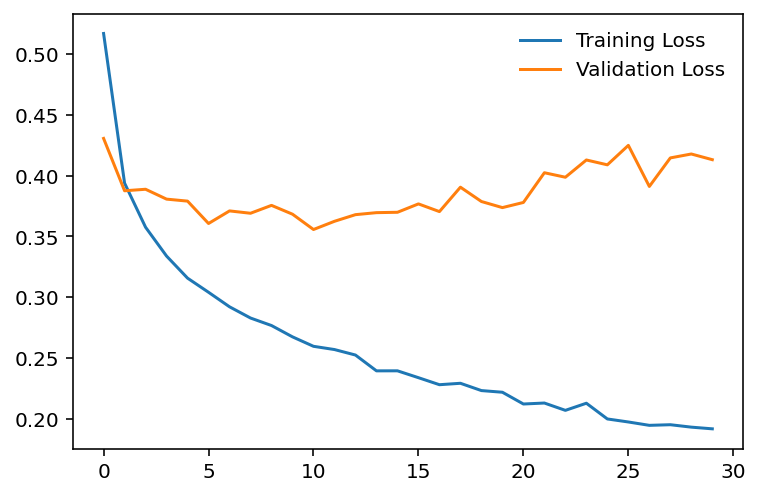

In [ ]:
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label = 'Validation Loss')
plt.legend(frameon=False)


From the above graph we can se that the model is OVERFITTING.

In [ ]:
# We will use dropout to reduce overfitting
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)
    
    # Dropout module with 0.2 drop probability
    self.dropout=nn.Dropout(p=0.2)


  def forward(self,x):
    # Make sure input tensor is flattened
    x = x.view(x.shape[0],-1)

    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))

    # Output so no dropout here
    x = F.log_softmax(self.fc4(x),dim=1)

    return x

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=0.003)

epochs =30
step=0

train_losses,test_losses = [],[]

for e in range(epochs):
  running_loss=0
  for images,labels in trainloader:

    optimizer.zero_grad()
    log_ps = model(images)
    loss   = criterion(log_ps,labels)
    loss.backward()
    optimizer.step()

    running_loss +=loss.item()
  
  else:
    test_loss = 0
    accuracy  = 0

    # Turn off the gradients for validation , saves memory and computations
    with torch.no_grad():
      model.eval()
      for images,labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps,labels)

        ps = torch.exp(log_ps)
        top_p,top_class = ps.topk(1,dim=1)

        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    model.train()
    
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))


    print("Epoch : {}/{}..".format(e+1,epochs),
          "Training Loss : {:.3f}..".format(running_loss/len(trainloader)),
          "Test Loss : {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy : {:.3f} %".format(accuracy/len(testloader)))

Epoch : 1/30.. Training Loss : 0.606.. Test Loss : 0.545.. Test Accuracy : 0.803 %
Epoch : 2/30.. Training Loss : 0.483.. Test Loss : 0.462.. Test Accuracy : 0.833 %
Epoch : 3/30.. Training Loss : 0.459.. Test Loss : 0.452.. Test Accuracy : 0.844 %
Epoch : 4/30.. Training Loss : 0.440.. Test Loss : 0.417.. Test Accuracy : 0.846 %
Epoch : 5/30.. Training Loss : 0.423.. Test Loss : 0.429.. Test Accuracy : 0.847 %
Epoch : 6/30.. Training Loss : 0.414.. Test Loss : 0.387.. Test Accuracy : 0.860 %
Epoch : 7/30.. Training Loss : 0.401.. Test Loss : 0.404.. Test Accuracy : 0.851 %
Epoch : 8/30.. Training Loss : 0.399.. Test Loss : 0.397.. Test Accuracy : 0.858 %
Epoch : 9/30.. Training Loss : 0.386.. Test Loss : 0.386.. Test Accuracy : 0.865 %
Epoch : 10/30.. Training Loss : 0.388.. Test Loss : 0.397.. Test Accuracy : 0.860 %
Epoch : 11/30.. Training Loss : 0.390.. Test Loss : 0.392.. Test Accuracy : 0.859 %
Epoch : 12/30.. Training Loss : 0.380.. Test Loss : 0.374.. Test Accuracy : 0.869 %
E

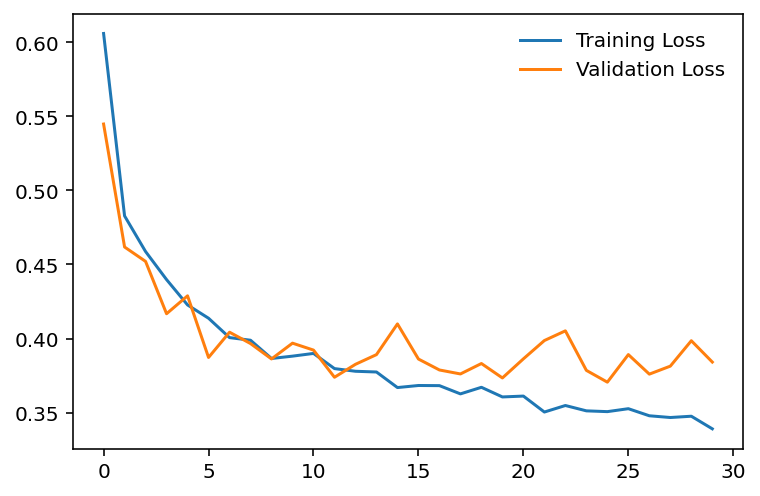

In [ ]:
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label = 'Validation Loss')
plt.legend(frameon=False)

In [ ]:
# Save and Loading Models
print("Our Model: \n\n",model,'\n')
print("The state dict keys : \n\n",model.state_dict().keys())

Our Model: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

The state dict keys : 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])
